# 🎥 Exploration 12 Main Project : Movielens 영화 SBR 🎥

## 🥏 루브릭 살펴보기 🥏

|루브릭 평가항목|세부기준|
|------|---|
|<span style="color:red">**Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정을 잘 녹여내었다.**</span>|데이터 셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정을 보여줄 것|
|<span style="color:blue">**RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련된다.**</span>|적절한 epoch만큼 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선될 것|
|<span style="color:purple">**세션정의, 모델구조, 하이퍼파라미터 등을 변경하여 Recall, MRR 등의 변화추이를 관찰했다.**</span>|3가지 이상의 변화를 시도하고 결과를 체계적으로 분석할 것|

## 🎮 프로젝트 진행 순서 🎮

1. 목표 및 참고사항 확인
2. 필요한 라이브러리 import
3. 데이터 불러오기
4. 데이터 전처리 I (Session Time 까지)
5. 데이터 전처리 II (Data Cleansing~)
6. 데이터 파이프라인 구축
7. Modeling I (Model Architecture 까지)
8. Modeling II (Model Training~)
9. 초기 훈련결과 분석
10. 특명 : 변화 추이 관찰
11. 프로젝트 회고

## 1. 목표 및 참고사항 확인

- **목표 : Movielens 1M Dataset을 기반으로 Session Based Recommendation 시스템을 구현하고 Recall, MRR 등의 변화추이를 분석한다.**
- 이 데이터셋은 노드의 연습과정에서 사용했던 SessionID 대신 UserID 항목을 사용한다.
- 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하고 있지 않으므로, 본 프로젝트에서는 UserID가 SessionID의 역할을 담당하게 된다.
- Rating 정보가 포함되어 있다. 직전에 봤던 영화가 마음에 들었는지의 여부가 비슷한 영화를 더 고르게 하는 것과 관련이 있을 수 있기 때문이다.
- Rating이 낮은 데이터를 어떻게 처리할지 고민해보는 것도 좋다.
- Time 항목에는 협정 세계시(UTC Time)가 포함되어 있으며 1970.01.01 부터 경과된 '초' 단위의 시간이 기재되어 있다.

#### 참고 - 협정 세계시 (출처 : 네이버)

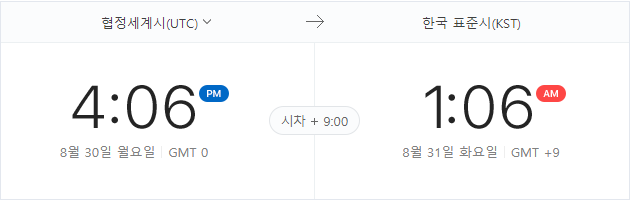

## 2. 필요한 라이브러리 import

- 이번 스텝에서는 프로젝트 수행에 필요한 라이브러리를 불러오는 작업만 진행한다.
- 아래 코드에서 **pathlib**이라는 다소 생소한 라이브러리 이름이 나오는데.. 어떤 일을 하는지 알아보고 오는 것도 좋다!
(https://brownbears.tistory.com/415#:~:text=pathlib%20%EC%84%A4%EB%AA%85,%EB%A1%9C%20%EB%8B%A4%EB%A3%A8%EC%9E%90%EB%8A%94%20%EA%B2%83%EC%9E%85%EB%8B%88%EB%8B%A4.&amp;text=pathlib%EC%9D%80%20%EC%8A%AC%EB%9E%98%EC%8B%9C(/)%EA%B0%80,%EC%A7%81%EA%B4%80%EC%A0%81%EC%9C%BC%EB%A1%9C%20%EC%9D%B4%ED%95%B4%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%8A%B5%EB%8B%88%EB%8B%A4)
- pathlib 라이브러리는 **파일 시스템 경로를 객체로 다루는 것이 특징**이다.

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print('라이브러리가 무사히 import 되었군요.')

라이브러리가 무사히 import 되었군요.


## 3. 데이터 불러오기

- 총 데이터 row 수가 무려 **100만 개가 넘는다!** 😅😅
- 출력해 보면, index 순서대로 정렬되어 있지 않음을 알 수 있다.
- 전체 데이터를 UserID와 Time 순서대로 정렬하기 때문에, **index는 순서대로 정렬되지 않는다.** 이것이 31, 22, 27, 37, 24 등과 같이 나타나는 이유이다.

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 목표에 의해 유저(or 세션) 수와 아이템 수, 시간의 수를 **nunique()** 메서드를 이용해 확인한다.

In [3]:
# 유저 수와 영화 수, 시간 수 확인
print('Unique 한 유저의 수는', data['UserId'].nunique(), '개 입니다!')
print('Unique 한 영화의 수는', data['ItemId'].nunique(), '개 입니다!')
print('Unique 한 시간의 수는', data['Time'].nunique(), '개 입니다!')

Unique 한 유저의 수는 6040 개 입니다!
Unique 한 영화의 수는 3706 개 입니다!
Unique 한 시간의 수는 458455 개 입니다!


## 4. 데이터 전처리 I

### 1) Session ID 정의

- 본 프로젝트에서는 SessionID 대신 UserID를 사용하고 있다.
- UserID가 SessionID 역할을 할 수 있도록 **Session의 기준을 설정**한다.

In [4]:
# UserId와 Time을 기준으로 새로운 데이터프레임 생성
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
# SessionId 컬럼 추가
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 2) Session Length (세션단위 정의 과정 : 길이 분석)

- 위에서 설정한 SessionId를 가지고 몇 개의 영화에 평점을 남겼는지 살펴본다.
- 아래 코드에서 session_length는 **같은 SessionId를 공유하는 데이터 행의 수**를 의미한다.
- 위의 표를 보면 **SessionId가 1인 데이터 row의 수는 3**이므로 SessionId가 1일 때는 3으로 대응된다.

In [6]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

- 길이의 **중앙값(median)** 과 **평균(mean)** 을 알아본다.

In [7]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

- 길이의 **최솟값(min)** 과 **최댓값(max)** 을 알아본다.
- 모든 세션에서 최소 하나의 영화에 평점을 남겼으며, 많게는 30편의 영화에 평점을 남긴 세션도 있다.

In [8]:
session_length.min(), session_length.max()

(1, 30)

- 평점을 준 횟수에 따른 세션의 수도 알아본다.

In [9]:
length_count = session_length.groupby(session_length).size()
length_count

1     226181
2     110199
3      62860
4      34081
5      18354
6       9656
7       5013
8       2458
9       1232
10       661
11       106
12        83
13        85
14        48
15        38
16        29
17        16
18        13
19         9
20        14
21         6
22         7
23         5
25         2
26         2
27         2
28         2
30         1
dtype: int64

- **quantile(A)** 메서드로 (A×100)% 범위에 속하는 session_length가 얼마인지 알아본다.
- quantile(A) 메서드에서 A에는 0과 1 사이의 값이 들어간다.

In [10]:
## 95%, 99%, 99.9%, 99.99%
print('전체의 95% 정도는', session_length.quantile(0.95), '개의 영화에 평점을 남겼습니다.')         # 95 백분위수
print('전체의 99% 정도는', session_length.quantile(0.99), '개의 영화에 평점을 남겼습니다.')         # 99 백분위수
print('전체의 99.9% 정도는', session_length.quantile(0.999), '개의 영화에 평점을 남겼습니다.')      # 99.9 백분위수
print('전체의 99.99% 정도는', session_length.quantile(0.9999), '개의 영화에 평점을 남겼습니다.')    # 99.99 백분위수

전체의 95% 정도는 5.0 개의 영화에 평점을 남겼습니다.
전체의 99% 정도는 8.0 개의 영화에 평점을 남겼습니다.
전체의 99.9% 정도는 10.0 개의 영화에 평점을 남겼습니다.
전체의 99.99% 정도는 19.0 개의 영화에 평점을 남겼습니다.


- 전체 세션의 99.99%가 남긴 평점의 개수는 19개였다.
- 길이가 최댓값 30인 세션 중 하나를 집어 살펴본다.
- 실제로 index 값을 하나씩 바꾸어 본 결과, **index[1]에서부터 Error가 발생**하였다.
- 따라서 평점을 남긴 영화의 편수가 30인 세션은 1개임을 알 수 있다.
- 같은 방법으로 영화의 편수가 29인 세션은 없었으며, 28인 세션은 2개였다!

In [11]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


In [12]:
## 아래 코드는 에러입니다. 궁금하시면 주석을 풀고 돌려보세요!
# long_session = session_length[session_length==30].index[1]
# data[data['SessionId']==long_session]

- 아래 코드는 **session_length 기준 하위 99.9% 까지의 분포 누적합을 시각화**하여 보여준다.
- **cumsum()** 메서드는 누적 합을 도출하는 메서드이다.
- **'cum family'** : https://rfriend.tistory.com/231
- 아래 코드를 해석하면 **session_length가 1인 데이터는 약 48%, 5 이하인 데이터는 약 95.86% 정도가 분포**하여 있음을 알 수 있다. 😉😉😉

In [13]:
## 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

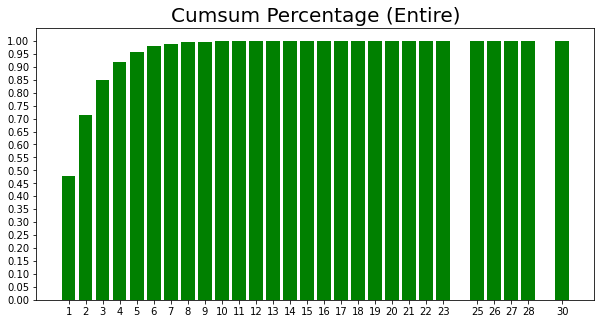

In [14]:
## 전체 분포 누적합 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='green')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage (Entire)', size=20)
plt.show()

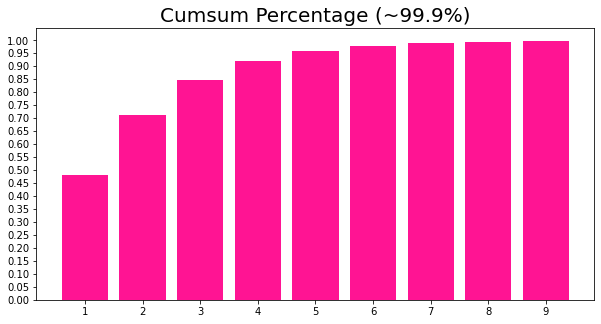

In [15]:
## 하위 99.9%까지의 분포 누적합 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='deeppink')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage (~99.9%)', size=20)
plt.show()

### 3) Session Time (세션단위 정의 과정 : 시간 분석)

- 우리가 다루려고 하는 데이터의 시간단위 정보를 살펴본다.

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()  # Time 데이터의 초단위 최솟값, 최댓값
print(oldest)
print(latest)

956703932
1046454590


In [17]:
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))   # oldest 값에 대한 협정 세계시
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))   # latest 값에 대한 협정 세계시

2000-04-25 23:05:32
2003-02-28 17:49:50


- 아래 코드에서 86400의 의미는 **1일을 '초(second)' 단위로 환산한 값**이다. (24×60×60)

In [18]:
print('최근 3년간 Time 데이터 수는', len(data[data['Time'] > latest - (86400*365*3)]), '입니다.')
print('최근 2년간 Time 데이터 수는', len(data[data['Time'] > latest - (86400*365*2)]), '입니다.')
print('최근 1년간 Time 데이터 수는', len(data[data['Time'] > latest - (86400*365*1)]), '입니다.')

최근 3년간 Time 데이터 수는 1000209 입니다.
최근 2년간 Time 데이터 수는 69349 입니다.
최근 1년간 Time 데이터 수는 21704 입니다.


- 앞에서 살펴본 session_length 분포를 생각해보면, session_length가 작은 쪽으로 몰려있었음을 알 수 있다.
- 원래 추천시스템 구축에서는 최신의 트렌드를 반영하는 것이 효과적이긴 하나, 분포적 특성에 의해 여기서는 사실상 모든 데이터셋을 사용한다.

In [19]:
years_ago = latest - (86400*365*3)   # 최종 날짜로부터 3년 이전 날짜를 구한다.  
data = data[data['Time'] > years_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


## 5. 데이터 전처리 II

### 1) Data Cleansing

- Data Cleansing 단계의 아이디어 : **Rating이 낮은 데이터를 어떻게 처리할 것인가?**
- 우선, Rating 데이터 또한 매우 많으니, Rating의 최솟값과 최댓값부터 구해보자.

In [20]:
print('유저가 준 평점의 최솟값은', data['Rating'].min(), '점입니다.')
print('유저가 준 평점의 최댓값은', data['Rating'].max(), '점입니다.')

유저가 준 평점의 최솟값은 1 점입니다.
유저가 준 평점의 최댓값은 5 점입니다.


- Rating의 값이 일정 수준 이상인 데이터의 개수를 살펴본다.

In [21]:
print(len(data[data['Rating'] >= 1]))   # 평점의 최솟값이 1이므로 Entire Data의 개수가 나온다.
print(len(data[data['Rating'] >= 2]))   # 평점이 2점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 3]))   # 평점이 3점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 4]))   # 평점이 4점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 5]))   # 평점의 최댓값을 준 데이터의 개수이다.

1000209
944035
836478
575281
226310


In [22]:
data = data[data['Rating'] >= 3]
data = data[['SessionId', 'UserId', 'Time', 'ItemId', 'Rating']]
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,978300019,3186,4
1,1,1,978300055,1270,5
2,1,1,978300055,1721,4
3,1,1,978300055,1022,5
4,2,1,978300103,2340,3
...,...,...,...,...,...
1000204,471159,6040,997454429,2917,4
1000205,471160,6040,997454464,1921,4
1000206,471160,6040,997454464,1784,3
1000207,471161,6040,997454486,161,3


### 2) 훈련 데이터, 테스트 데이터, 검증 데이터 나누기

- 전체 데이터에서 **맨 마지막 날로부터 120일까지**를 **test set**로 정의한다.
- 전체 데이터에서 **맨 마지막 날로부터 240일까지 데이터 중 test set이 아닌 데이터**를 **validation set**로 정의한다.

In [23]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [24]:
tr, test = split_by_date(data, n_days=120)
tr, val = split_by_date(tr, n_days=120)

- 나누어진 세 종류의 데이터에 대한 정보를 살펴보기 위해 함수 정의를 활용한다.

In [25]:
def stats_info(data: pd.DataFrame, status: str):
    first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
    last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {first_time}\n'
          f'\t Last Time : {last_time}\n')

In [26]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 826182
	 Sessions: 6038
	 Items: 3622
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-03 16:04:32

* valid Set Stats Info
	 Events: 4939
	 Sessions: 269
	 Items: 1826
	 First Time : 2002-07-03 17:31:04
	 Last Time : 2002-10-31 16:33:08

* test Set Stats Info
	 Events: 5351
	 Sessions: 271
	 Items: 1809
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2003-02-28 17:49:50



- train set에 없는 아이템이 validation이나 test 기간에 생길 수도 있어서 train data를 기준으로 인덱싱한다.

In [27]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값으로(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- 데이터 준비 및 전처리를 마무리하고 지금까지의 데이터를 저장한다!

In [28]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 6. 데이터 파이프라인 구축

### 1) SessionDataset

- 이 과정은 **Session-Parallel Mini-Batch를 구현하는 과정**이라고 이해하면 된다.

In [29]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [30]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


- train data로 SessionDataset 객체를 만들고 각 변수들을 살펴본다.

In [31]:
## click_offsets - 각 세션이 시작된 index를 담고 있다.
tr_dataset.click_offsets

array([     0,      1,      4, ..., 826180, 826181, 826182], dtype=int32)

In [32]:
## session_idx - 각 세션을 indexing한 Numpy Array이다.
tr_dataset.session_idx

array([     0,      1,      2, ..., 415853, 415854, 415855])

### 2) SessionDataLoader

- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 하나 설정한다.

In [33]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):   ## 모델 input, label, session이 끝나는 곳의 위치를 생성하는 함수
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [34]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


In [35]:
iter_ex = iter(tr_data_loader)

In [36]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


## 7. Modeling I

### 1) Evaluation Metric (평가 지표)

- 이번 프로젝트에서는 평가 지표로 **MRR**과 **Recall**을 사용할 것이다.
- 여기서 **MRR**은 정답 데이터의 index를 역수화한 값이다.
- 루브릭에서도 해당 평가 지표를 기반으로 개선 및 분석이 이루어진다.

In [37]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 2) Model Architecture

- 프로젝트에서 사용되는 모델 구조는 노드에서 소개된 **GRU4REC**을 사용한다.
- **GRU4REC 더 자세히 알아보기** : https://blog.naver.com/stu5073/222208516966

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print('아키텍쳐 구현을 위한 라이브러리를 불러왔다!')

아키텍쳐 구현을 위한 라이브러리를 불러왔다!


In [39]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- 이 모델에는 다양한 하이퍼파라미터를 사용하게 된다.
- 다양한 하이퍼파라미터를 활용해야 하는 만큼 **클래스로 관리**하고자 한다.

In [40]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=7, k=50)

In [41]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3622)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    551100    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3622)               184722    
Total params: 735,822
Trainable params: 735,822
Non-trainable params: 0
_________________________________________________________________


## 8. Modeling II

### 1) Model Training

- 여기까지 구축된 모델을 가지고 학습을 진행한다.
- 하이퍼 파라미터를 어떻게 조작하느냐에 따라 학습 시간에 차이가 있을 수 있다.. ㅠㅠ 😂😂😂

In [42]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    
def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [43]:
## 모델 학습 시도
train_model(model, args)

Train:   0%|          | 0/1602 [00:00<?, ?it/s, accuracy=0, train_loss=8.16]      

	 - Recall@50 epoch 1: 0.077148
	 - MRR@50    epoch 1: 0.007257



Train:   0%|          | 0/1602 [00:00<?, ?it/s, accuracy=0.00391, train_loss=7.47]

	 - Recall@50 epoch 2: 0.112305
	 - MRR@50    epoch 2: 0.009321



Train:   0%|          | 0/1602 [00:00<?, ?it/s, accuracy=0.00391, train_loss=7.35]

	 - Recall@50 epoch 3: 0.115234
	 - MRR@50    epoch 3: 0.009731



Train:   0%|          | 0/1602 [00:00<?, ?it/s, accuracy=0, train_loss=7.3]       

	 - Recall@50 epoch 4: 0.115234
	 - MRR@50    epoch 4: 0.011260



Train:   0%|          | 0/1602 [00:00<?, ?it/s, accuracy=0, train_loss=7.28]      

	 - Recall@50 epoch 5: 0.117188
	 - MRR@50    epoch 5: 0.011359



Train:   0%|          | 0/1602 [00:00<?, ?it/s, accuracy=0, train_loss=7.26]      

	 - Recall@50 epoch 6: 0.120117
	 - MRR@50    epoch 6: 0.011496



Evaluation:  80%|████████  | 4/5 [00:13<00:03,  3.45s/it]

	 - Recall@50 epoch 7: 0.118164
	 - MRR@50    epoch 7: 0.011592



### 2) Inference (모델 평가)

- 테스트 모델함수를 정의하고 모델을 평가한다.

In [44]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  80%|████████  | 4/5 [00:06<00:01,  1.55s/it]

	 - Recall@50: 0.055664
	 - MRR@50: 0.013750



## 9. 초기 훈련결과 분석

- 초기 훈련 시에 설정한 값들은 다음과 같다.

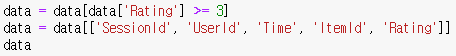

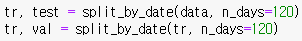

- 위 조건에서 훈련을 시도했을 때, 총 10번의 epoch 동안 대체로 감소하는 양상을 보였지만, 8번째 epoch에서 train loss가 잠시 증가한 부분이 있었다.
- 조금 더 안정적인 감소 추이를 위해 다음 스텝에서 몇 번의 시도를 해볼 것이다.

## 10. 특명 : 변화 추이 관찰

- 조금 더 training loss를 안정적으로 감소시키기 위해 이제부터 몇 번의 시도를 통해 더욱 나은 결과를 만들어 본다! 😀😀
- **이제부터 깔끔한 정리를 위해 각 결과를 아래와 같은 Formation으로 정리한다.**
1. Rating 제한 수치
2. test, val 나눈 일수
3. 클래스 내에 속한 하이퍼파라미터들
4. train loss의 안정적인 감소가 이루어졌다고 판단하는가? (Y, D, N) 🤍**D는 애매한 경우를 말한다.**🤍
5. 모델 평가로 얻은 Recall, MRR 값 (순서대로)

### 💚재시도 1번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 120일, val : 마지막 날로부터 121~240일
3. batch_size=128, hsz=50, drop_rate=0.2, lr=0.005, epochs=10, k=20
4. N (전체적으로 보았을 때 train loss가 줄었다 늘어나는 양상이 보인다)
5. 0.221094, 0.079609

### 💚재시도 2번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 120일, val : 마지막 날로부터 121~240일
3. batch_size=128, hsz=50, drop_rate=0.05, lr=0.02, epochs=10, k=20
4. N
5. 0.178906, 0.057060

### 💚재시도 3번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 120일, val : 마지막 날로부터 121~240일
3. batch_size=512, hsz=30, drop_rate=0.2, lr=0.05, epochs=5, k=15
4. D
5. 0.164062, 0.058561

### 💚재시도 4번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 120일, val : 마지막 날로부터 121~240일
3. batch_size=512, hsz=50, drop_rate=0.02, lr=0.0005, epochs=5, k=10
4. Y
5. 0.156250, 0.047252. 특히 이번 시도에서는 **Recall과 MRR 값이 epoch가 늘면서 계속 증가만 하였다.**

### 💚재시도 5번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 120일, val : 마지막 날로부터 121~240일
3. batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=20
4. Y (지금까지 한 5번의 시도 중 epochs 동안 **train_loss가 증가한 적이 한 번도 없었다(모두 유지 또는 감소했다)!😍😍**)
5. 0.055664, 0.013685

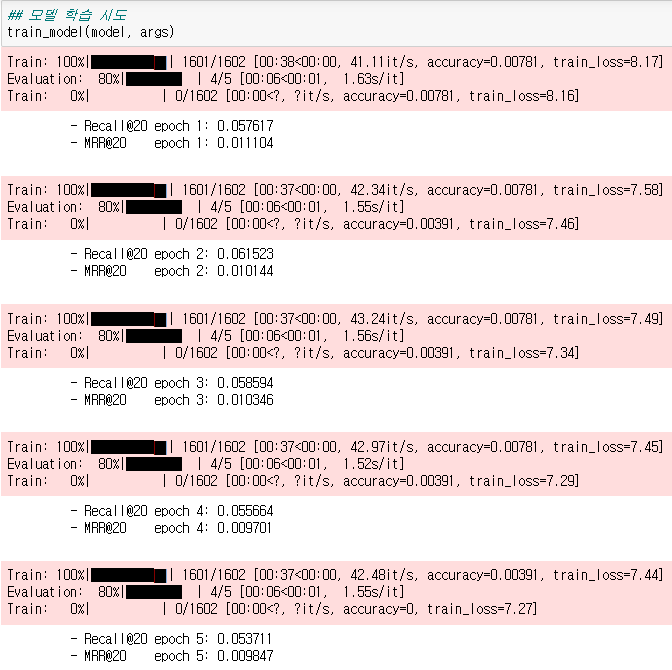

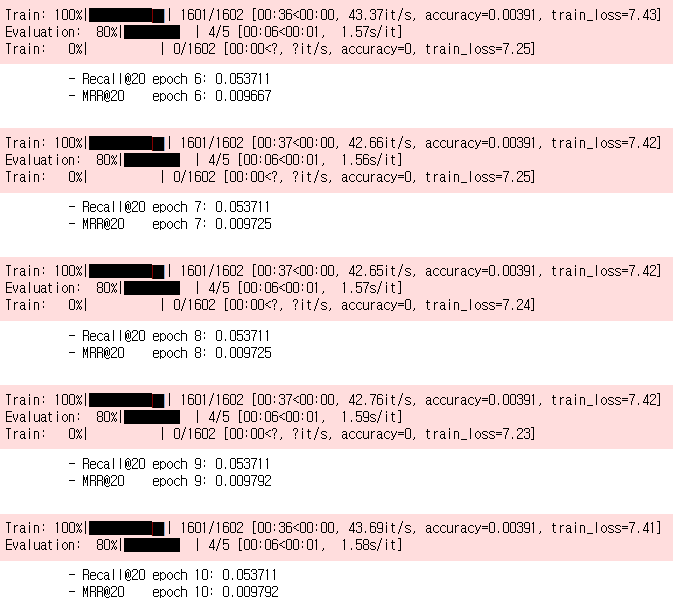

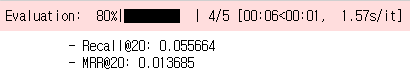

### 💜중간 점검💜

- 5번째 시도까지는 Rating과 test/val의 n_days 값을 그대로 두고, 모델의 args에 포함된 하이퍼 파라미터 튜닝을 시도했다.
- 다음 시도부터는 **5번째 시도의 하이퍼 파라미터와 Rating으로 test/val의 n_days 값만을 바꾸며 시도**하고자 한다.

### 💚재시도 6번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 80일, val : 마지막 날로부터 81~160일
3. batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=20
4. Y
5. 0.070312, 0.016585

### 💚재시도 7번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 100일, val : 마지막 날로부터 101~200일
3. batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=20
4. D
5. 0.062500, 0.015419

### 💜중간 점검💜

- 여기까지는 train/val 부분의 n_days split 값을 바꾸어 가며 모델 학습을 시도했다. 다른 파라미터는 건들지 않았다.
- 마지막으로 train/val 부분 n_days 값을 다시 120으로 하고, epoch 7에서 k의 값을 20보다 작은 시도 1번, 20보다 큰 시도 1번으로 총 2번의 시도를 더 하고 프로젝트를 마무리한다.
- k의 값이 혹시나 recall 값을 올리는 데 도움을 줄 수 있을까?

### 💚재시도 8번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 120일, val : 마지막 날로부터 121~240일
3. batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=7, k=10
4. Y
5. 0.055664, 0.013689

### 💚재시도 9번째💚

1. Rating 3점 이상
2. test : 마지막 날로부터 120일, val : 마지막 날로부터 121~240일
3. batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=7, k=50
4. Y
5. 0.055664, 0.013750

## 9. 프로젝트 회고

- 지금까지의 12개의 노드 중에서 가장 어려웠던 노드였다. 😥😥
- 노드에서는 Recall, MRR 값에 따른 성능 개선 관련 내용이 상세하게 나와 있지 않아 '개선되었다' 의 기준을 정확하게 이해하지는 못 했다.
- Recall 값만으로 놓고 봤을 때, 오히려 1번째 시도에서 가장 높은 값이 나왔다.
- MRR 값만으로 놓고 봤을 때, 역시나 1번째 시도에서 가장 높은 값이 나왔다.
- 해당 노드 질풍노드 스터디를 할 수 있게 된다면, 가장 많은 질문을 하게 될 것 같은 노드라고 생각한다.